In [3]:
import autograd.numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from scipy.interpolate import interp1d
from scipy.special import gamma
from ADVI import ADVI


In [2]:
data = pd.read_csv('taxi_porto/train.csv/train.csv')

: 

In [ ]:
data = data[data['MISSING_DATA']==False]


In [ ]:
data.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [ ]:
print(len(data))

1710660


In [ ]:
coordinates = data['POLYLINE'].apply(literal_eval)


KeyboardInterrupt: 

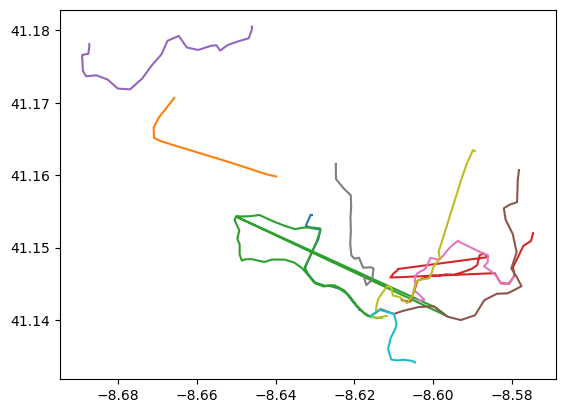

In [ ]:
for i in range(10):     
    plt.plot(np.array(coordinates[i])[:,0],np.array(coordinates[i])[:,1])

In [ ]:
coordinates_interp = []
for traj in coordinates:
    if len(traj)>0:
        x=np.array(traj)[:,0]
        y=np.array(traj)[:,1]
        t = np.linspace(0,50,len(x))
        t_interp = np.linspace(0,50,50)
        x_interp = np.interp(t_interp,t,x)
        y_interp = np.interp(t_interp,t,y)
        coordinates_interp.append([x_interp,y_interp])

In [ ]:
coordinates_interp = np.array(coordinates_interp)
print(coordinates_interp.shape)

(1704759, 2, 50)


In [ ]:
coordinates_1d = coordinates_interp.reshape(-1,100)
print(coordinates_1d.shape)
np.save('coordinates.npy',coordinates_1d)

NameError: name 'coordinates_interp' is not defined

In [4]:
coordinates_1d = np.load('coordinates.npy')[:50000]

In [5]:
M=100

def inv_T(x):
    return np.concatenate((x[:-M-1], np.exp(x[-M-1:])))


def grad_inv_T(x):
    return np.concatenate((0*x[:-M-1]+1, np.exp(x[-M-1:])))

def log_jac_inv_T(x):
    return np.concatenate((0*x[:-M-1], 1+0*np.exp(x[-M-1:])))

class taxi_distribution():
    def __init__(self, D, X):
        (self.N,self.D)=X.shape
        self.X = X
        self.M = M
        self.theta_size = self.D*self.M+self.N*self.M+self.M+1

    def log_gaussian(self,x,mu,sigma):
        return - 0.5*np.log((2*np.pi)**len(x)*np.linalg.det(sigma))-(x-mu)@np.linalg.inv(sigma)@(x-mu).T/2

    def log_loggaussian(self,x,mu,sigma):
        return - 0.5*np.log((2*np.pi)*(sigma)*x**2)-(np.log(x)-mu)*(sigma)*(np.log(x)-mu)

    def log_invgamma(self,x,a,b):
        return (b**a / gamma(a)) * x**(-a-1) * np.exp(-b / x)

    def log_distr(self,X,theta):
        sample = np.random.choice(X.shape[0],size=5000,replace=False)
        (W,Z,alpha,sigma) = theta[0:self.D*self.M], theta[self.D*self.M:self.D*self.M+self.N*self.M],theta[self.D*self.M+self.N*self.M:-1],theta[-1] 
        W = W.reshape((self.D,self.M))
        Z = Z.reshape((self.N,self.M))
        conditionnal = np.sum([self.log_gaussian(x,W@(Z[n]),np.eye(self.D)) for n,x in enumerate(X[sample])])
        distr_sigma = self.log_loggaussian(sigma,0,1)
        distr_z = np.sum([self.log_gaussian(z,np.zeros(self.M),np.eye(self.M)) for z in Z[sample]])
        distr_alpha = np.sum([self.log_invgamma(alpha_m,1,1) for alpha_m in alpha])
        distr_w = np.sum([self.log_gaussian(w,np.zeros(self.M),sigma*np.diag(alpha)) for w in W])

        return conditionnal + distr_sigma + distr_z + distr_alpha + distr_w
   
     


In [6]:
taxi_distr =taxi_distribution(M,coordinates_1d)

model = ADVI(inv_T,taxi_distr, coordinates_1d,dependant=False)
model.grad_inv_T=grad_inv_T
model.grad_logjac_inv_T = log_jac_inv_T

In [7]:
model.fit(lr=1,M=10,eps=1e-3,max_step=50)

2 [-0.99998305  0.99996389 -0.99998989 ...  0.99996147  0.99991087
  0.99999992] [1.00000778 1.0000053  1.00000523 ... 1.00002393 1.00003881 1.00000005]
-1596300720.3861895 1596300721.3861895
3 [-1.01424125  0.56709937 -0.81621353 ...  0.99899454  0.99919578
  1.00784156] [0.97233317 0.9468674  0.98365411 ... 0.9998928  0.99927297 0.99910017]
-363274763.38298297 0.7724271130472855
4 [-0.59767528  0.2683244  -0.94091143 ...  0.99809582  0.99838527
  1.00770058] [1.01152593 0.93030924 0.94109438 ... 0.9991943  0.99898852 0.99901519]
-506251442.1715309 0.3935772401503557
5 [-0.36728574  0.84009954 -1.02677616 ...  1.00034884  1.00157812
  1.00773776] [0.96534769 0.85744201 0.95133115 ... 0.99451783 0.99681815 0.99879826]
-638123708.2779075 0.26048768481669804
6 [-1.75753166  0.31820988  0.31105413 ...  1.00305287  1.00107305
  1.00779484] [0.24449384 0.82674314 0.77910777 ... 0.99144841 0.99612204 0.99864676]
-6747832022.316783 9.574488825257772
7 [-1.71786052  0.17263557  0.31352468 ... 

KeyboardInterrupt: 

In [8]:
import numpy as np
np.save('mean_theta.npy',model.mu)

(100, 100)


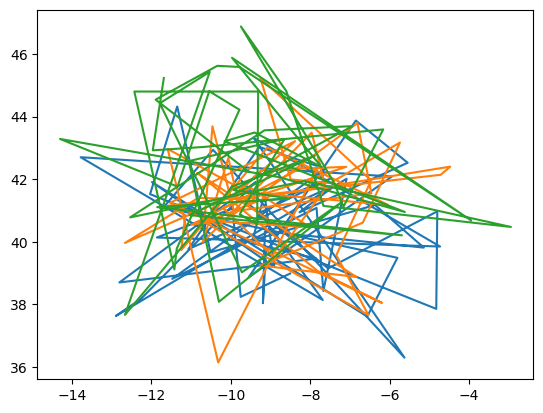

In [11]:
(N,D)=coordinates_1d.shape
theta = model.mu
(W,Z,alpha,sigma) = theta[0:D*M], theta[D*M:D*M+N*M],theta[D*M+N*M:-1],theta[-1] 
W = W.reshape((D,M))
Z = Z.reshape((N,M))
print(W.shape)
for i in range(5,8):
    res = W@(Z[i])
    x,y = res[0:50],res[50:]
    plt.plot(x,y)

In [16]:
from sklearn.mixture import GaussianMixture
model_cluster = AgglomerativeClustering()

model_cluster.fit(Z)

: 

In [15]:
for i in range(8):
    print(coordinates_1d[model_cluster.labels_==i,:50].mean(),coordinates_1d[model_cluster.labels_==i,50:].mean())

-8.618514607960092 41.159395145271446
-8.618795850498229 41.160020393804146
-8.61930646600567 41.15919930859628
-8.618960898442259 41.15995943390623
-8.619395491993881 41.15994308280508
-8.619405318140739 41.159164814627914
-8.618735830274263 41.159295972287296
-8.61876161450225 41.159230081509016


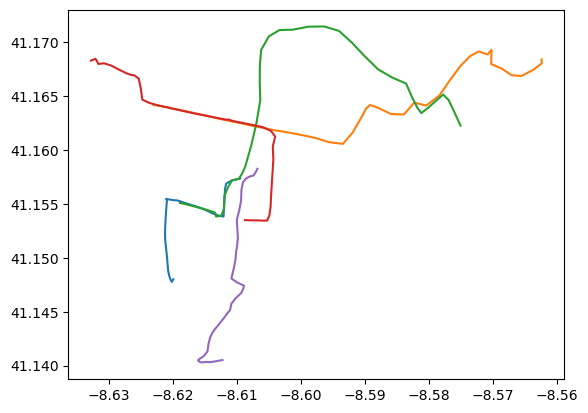

In [23]:
for i in range(10,15):
    x,y = coordinates_1d[i,:50], coordinates_1d[i,50:]
    plt.plot(x,y)